پروژه پایانی درس هوش مصنوعی دکتر ذبیحی فر .
دی ماه 1403

مریم هشیاریپور- ش.دانشجویی:98543125

امیرصالح رضائی- ش.دانشجویی:99543298

محمد طالبی-ش.دانشجویی:99542231

# بخش 1 : نصب کتابخانه ها

In [1]:
!pip install pandas numpy
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
!pip install seaborn
!pip install numpy
!pip install kagglehub
!pip install split-folders

In [13]:
!pip install pydot
!pip install Graphviz

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

tf.random.set_seed(3)


# بخش 2: فراخوانی دیتاست و تقسیم آن

دیتاست استفاده شده :

 https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd?utm_source=chatgpt.com

In [3]:


import kagglehub


path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
print("Path to dataset files:", path)



100%|██████████| 2.58G/2.58G [00:19<00:00, 146MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1


In [4]:

# بررسی ساختار پوشه‌ها
import os
data_dir = "/root/.cache/kagglehub/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)"  # در صورت نیاز اصلاح کنید
print("پوشه‌های موجود در data_dir:")
print(os.listdir(data_dir))

# مسیر خروجی پوشه‌های train/test/val
output_dir = "/kaggle/working/splitted_Data"

# تقسیم دیتاست به نسبت (80% train, 15% val, 5% test)
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05), group_prefix=None)

print("دیتاست با موفقیت به پوشه‌های train، test و val تقسیم شد.")

پوشه‌های موجود در data_dir:
['Non Drowsy', 'Drowsy']


Copying files: 41793 files [00:19, 2101.72 files/s]

دیتاست با موفقیت به پوشه‌های train، test و val تقسیم شد.


In [6]:
import os

# مسیر پوشه‌های تولیدشده توسط splitfolders
train_dir = "/kaggle/working/splitted_Data/train"
test_dir = "/kaggle/working/splitted_Data/test"
val_dir = "/kaggle/working/splitted_Data/val"

# بررسی پوشه‌های هر بخش
print("پوشه‌های درون train_dir:", os.listdir(train_dir))
print("پوشه‌های درون test_dir:", os.listdir(test_dir))
print("پوشه‌های درون val_dir:", os.listdir(val_dir))


پوشه‌های درون train_dir: ['Non Drowsy', 'Drowsy']
پوشه‌های درون test_dir: ['Non Drowsy', 'Drowsy']
پوشه‌های درون val_dir: ['Non Drowsy', 'Drowsy']


In [7]:
import os
import shutil

# مسیر پوشه‌های train، test و val
base_split_path = "/kaggle/working/splitted_Data"
split_dirs = ['train', 'test', 'val']
unwanted_folder = "Driver Drowsiness Dataset (DDD)"

for split in split_dirs:
    split_path = os.path.join(base_split_path, split)
    unwanted_path = os.path.join(split_path, unwanted_folder)

    if os.path.exists(unwanted_path):
        shutil.rmtree(unwanted_path)
        print(f"پوشه‌ی اضافی '{unwanted_folder}' در '{split}' حذف شد.")
    else:
        print(f"پوشه‌ی اضافی '{unwanted_folder}' در '{split}' یافت نشد.")


پوشه‌ی اضافی 'Driver Drowsiness Dataset (DDD)' در 'train' یافت نشد.
پوشه‌ی اضافی 'Driver Drowsiness Dataset (DDD)' در 'test' یافت نشد.
پوشه‌ی اضافی 'Driver Drowsiness Dataset (DDD)' در 'val' یافت نشد.


In [8]:
import os

# مسیر پوشه‌های train، test و val
base_split_path = "/kaggle/working/splitted_Data"
split_dirs = ['train', 'test', 'val']
classes = ['Drowsy', 'Non Drowsy']

for split in split_dirs:
    split_path = os.path.join(base_split_path, split)
    print(f"\nشمارش تصاویر در پوشه '{split}':")
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        if os.path.exists(cls_path):
            num_images = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
            print(f"تعداد تصاویر در کلاس '{cls}': {num_images}")
        else:
            print(f"پوشه‌ی کلاس '{cls}' در '{split}' وجود ندارد.")



شمارش تصاویر در پوشه 'train':
تعداد تصاویر در کلاس 'Drowsy': 17878
تعداد تصاویر در کلاس 'Non Drowsy': 15556

شمارش تصاویر در پوشه 'test':
تعداد تصاویر در کلاس 'Drowsy': 1118
تعداد تصاویر در کلاس 'Non Drowsy': 973

شمارش تصاویر در پوشه 'val':
تعداد تصاویر در کلاس 'Drowsy': 3352
تعداد تصاویر در کلاس 'Non Drowsy': 2916


# بخش 3: تعیین مسیر و ساخت ImageDataGenerator

In [9]:
# بخش 3: تعیین مسیر و ساخت ImageDataGenerator

import os
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# مسیر پوشه‌های تولیدشده توسط splitfolders
train_dir = "/kaggle/working/splitted_Data/train"
test_dir = "/kaggle/working/splitted_Data/test"
val_dir = "/kaggle/working/splitted_Data/val"

# تعریف ImageDataGenerator برای هر بخش
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# ساختن batch‌ها (جریان تصاویر) از روی پوشه‌ی train
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # سایز ورودی شبکه
    batch_size=32,           # تعداد تصاویری که در هر batch به مدل می‌دهیم
    class_mode='categorical',  # تغییر به 'categorical' برای دو کلاس
    shuffle=True             # برای تصادفی کردن ترتیب داده‌ها
)

# ساختن batch‌ها (جریان تصاویر) از روی پوشه‌ی test
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # تغییر به 'categorical'
    shuffle=False            # برای ارزیابی بهتر
)

# ساختن batch‌ها (جریان تصاویر) از روی پوشه‌ی val
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # تغییر به 'categorical'
    shuffle=False            # برای ارزیابی بهتر
)

print("جنراتورهای تصاویر با موفقیت ساخته شدند.")




Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
جنراتورهای تصاویر با موفقیت ساخته شدند.


# بخش 4: نمایش ۱۰ تصویر نمونه از هر کلاس از دیتاست

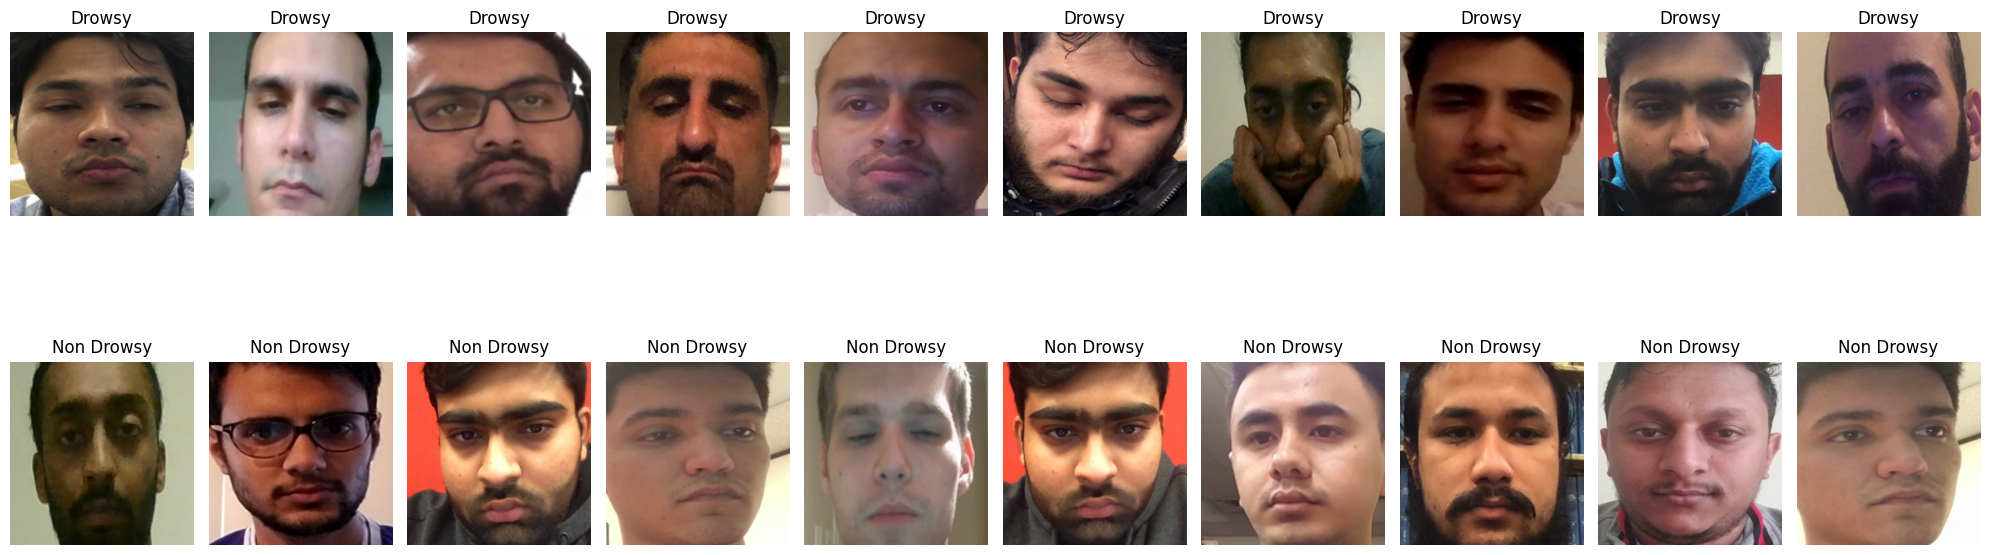

In [ ]:


import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# مسیر پوشه‌ی آموزش که توسط split-folders ایجاد شده است
train_dir = "/kaggle/working/splitted_Data/train"

# تعریف نام کلاس‌ها
class_names = ['Drowsy', 'Non Drowsy']

# تعداد نمونه از هر کلاس که می‌خواهیم نمایش دهیم
num_samples_per_class = 10

# لیست برای نگهداری مسیرهای انتخاب شده
selected_image_paths = []

# برای هر کلاس، ۱۰ تصویر به‌صورت تصادفی انتخاب می‌کنیم
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    # لیست تمام فایل‌های تصویری در کلاس
    all_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)
                 if img.endswith('.png') or img.endswith('.jpg') or img.endswith('.jpeg')]

    # اطمینان از اینکه تعداد تصاویر کافی وجود دارد
    if len(all_images) < num_samples_per_class:
        print(f"تعداد تصاویر کافی در کلاس {class_name} وجود ندارد. فقط {len(all_images)} تصویر موجود است.")
        selected_images = all_images  # انتخاب تمام تصاویر موجود
    else:
        # انتخاب تصادفی ۱۰ تصویر
        selected_images = random.sample(all_images, num_samples_per_class)

    selected_image_paths.extend(selected_images)

# تنظیم اندازه شکل کلی نمودار
plt.figure(figsize=(20, 8))

# تعداد کل تصاویر برای تنظیم ساب‌پلات
total_images = len(selected_image_paths)

# نمایش هر تصویر در یک ساب‌پلات جداگانه
for i, img_path in enumerate(selected_image_paths):
    plt.subplot(len(class_names), num_samples_per_class, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    # استخراج نام کلاس از مسیر فایل
    class_label = os.path.basename(os.path.dirname(img_path))
    plt.title(f"{class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [10]:


train_class_indices = train_batches.class_indices
test_class_indices  = test_batches.class_indices
val_class_indices   = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels  = test_batches.classes
val_class_labels   = val_batches.classes

train_class_counts = Counter(train_class_labels)
test_class_counts  = Counter(test_class_labels)
val_class_counts   = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print()

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print()

print("Class Names for validation:\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)


Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class Names for validation:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})


# بخش 6: ساخت مدل

In [11]:


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# تعیین سایز تصویر ورودی
image_size = (224, 224)

# بارگذاری مدل MobileNetV2 بدون لایه‌های بالایی
base_model = MobileNetV2(
    weights='imagenet',       # استفاده از وزن‌های از پیش آموزش‌داده شده
    include_top=False,        # لایه‌های بالایی حذف شوند تا بتوانیم لایه‌های خود را اضافه کنیم
    input_shape=(image_size[0], image_size[1], 3)
)

# فریز کردن تعدادی از لایه‌ها (اینجا 25 لایه آخر قابل آموزش باقی می‌مانند)
for layer in base_model.layers[:-25]:
    layer.trainable = False

# اضافه کردن لایه‌های پایانی دلخواه
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# لایه خروجی با دو نورون و تابع فعال‌سازی Softmax (دو کلاس)
predictions = Dense(2, activation='softmax')(x)

# ساخت مدل نهایی
model = Model(inputs=base_model.input, outputs=predictions)

# خلاصه ساختار مدل
model.summary()





9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 67,010,114 (255.62 MB)

 Trainable params: 66,114,050 (252.21 MB)

 Non-trainable params: 896,064 (3.42 MB)

In [12]:
import numpy as np

print("Unique labels in training data:", np.unique(train_batches.classes))
print("Unique labels in test data:", np.unique(test_batches.classes))
print("Unique labels in validation data:", np.unique(val_batches.classes))


Unique labels in training data: [0 1]
Unique labels in test data: [0 1]
Unique labels in validation data: [0 1]


# بخش 7: کامپایل و آموزش مدل

In [15]:


from tensorflow.keras.optimizers import Adam

# کامپایل مدل با استفاده از categorical_crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # تغییر به categorical_crossentropy
    metrics=['accuracy']
)

# آموزش مدل
history = model.fit(
    train_batches,
    epochs=10,             # تعداد epoch
    validation_data=val_batches
)






Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 539s 496ms/step - accuracy: 0.9257 - loss: 0.2261 - val_accuracy: 0.9949 - val_loss: 0.0136
Epoch 2/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 488s 464ms/step - accuracy: 0.9937 - loss: 0.0172 - val_accuracy: 0.9986 - val_loss: 0.0047
Epoch 3/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 486s 449ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 4/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 474s 451ms/step - accuracy: 0.9970 - loss: 0.0115 - val_accuracy: 0.9982 - val_loss: 0.0080
Epoch 5/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 505s 454ms/step - accuracy: 0.9971 - loss: 0.0098 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 6/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 498s 451ms/step - accuracy: 0.9979 - loss: 0.0076 - val_accuracy: 0.9971 - val_loss: 0.0130
Epoch 7/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 505s 453ms/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9989 - val_loss: 0.0043
Epoch 8/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 476s 452ms/step - accuracy: 0.9

# نمایش شماتیک مدل

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.623077 to fit



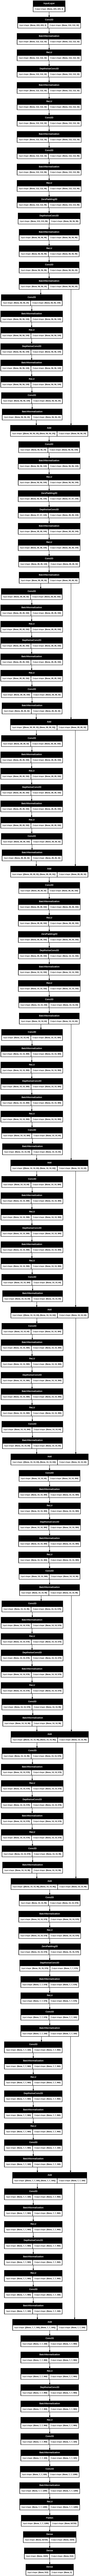

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

# بخش 8: ذخیره مدل

In [18]:


model_save_path = "/content/drive/MyDrive/Driver Drowsiness Detection prooo/driver_drowsiness_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/Driver Drowsiness Detection prooo/driver_drowsiness_model.h5


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# بخش 9: گزارش Confusion Matrix و Classification Report

66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step
Confusion Matrix:
[[1118    0]
 [   0  973]]


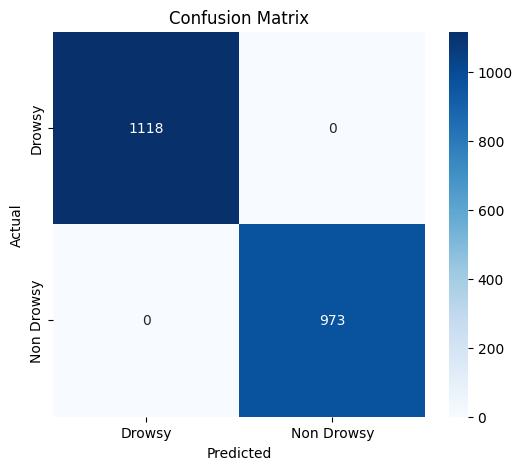

Classification Report:
              precision    recall  f1-score   support

      Drowsy       1.00      1.00      1.00      1118
  Non Drowsy       1.00      1.00      1.00       973

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091



In [19]:


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# پیش‌بینی مدل روی داده‌های تست
y_pred_prob = model.predict(test_batches)
# تبدیل پیش‌بینی‌ها به برچسب‌های 0 و 1 با آستانه 0.5
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# برچسب‌های واقعی
y_actual = test_batches.classes

# ساخت ماتریس سردرگمی
conf_matrix = confusion_matrix(y_actual, y_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

# مصورسازی ماتریس سردرگمی
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=train_class_indices.keys(),
    yticklabels=train_class_indices.keys()
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# گزارش طبقه‌بندی
report = classification_report(y_actual, y_pred_labels, target_names=train_class_indices.keys())
print("Classification Report:")
print(report)


# بخش 10: ذخیره کلاس‌ها

In [20]:


import json

# ذخیره کلاس‌ها (برچسب‌ها)
class_indices = train_batches.class_indices  # {'Drowsy': 0, 'Non Drowsy': 1}
class_labels_path = "/content/drive/MyDrive/Driver Drowsiness Detection prooo/class_labels.json"

# ذخیره در فایل JSON
with open(class_labels_path, 'w') as json_file:
    json.dump(class_indices, json_file)

print(f"کلاس‌ها با موفقیت در مسیر {class_labels_path} ذخیره شدند.")






کلاس‌ها با موفقیت در مسیر /content/drive/MyDrive/Driver Drowsiness Detection prooo/class_labels.json ذخیره شدند.
